In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using DifferentialEquations, Plots

In [3]:
# paramètres
E_s = 0.2
E_x = 0.85
T_s = 10.0
T_x = 9.0

par_effort = [E_s, E_x, T_s, T_x]

function effort(t, pars)
    E_s, E_x, T_s, T_x = pars

    if t < T_s || t >= T_s + T_x
        return E_s
    elseif t >= T_s && t < T_s + T_x
        return E_x
    end
end

effort (generic function with 1 method)

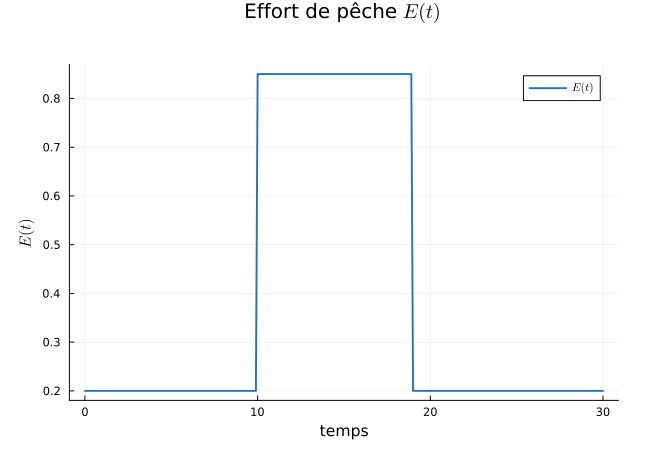

In [4]:
#| output: true
#| code-fold: true
time2plot = 0: .1: 30

plot(time2plot, [effort(t, par_effort) for t in time2plot],
     palette = :tab10,
     linewidth = 2,
     label = "\$E(t)\$",
     xlabel = "temps",
     ylabel = "\$E(t)\$",
     title = "Effort de pêche \$E(t)\$",
     margin = .5Plots.cm,
     topmargin = 1Plots.cm)

In [5]:
function allee_evar(u, p, t)
    r, K, epsilon = p[1]        # unpacking model parameters
    par_effort = p[2]           # unpacking fishing effort parameters
    E = p[3]                    # unpacking fishing effort function
    x = u[1]                    # use x notation
    dx = r*x*(x/epsilon - 1)*(1 - x/K) - E(t, par_effort)*x
end

allee_evar (generic function with 1 method)

In [6]:
x0 = 10.

tspan = (0.0, 30.0)
tstep = 0.1

r = 1.
K = 10.
epsilon = 2.                 # seuil de Allee
par_allee = [r, K, epsilon] # packing
tspan_allee = (0.0, 3.0)

(0.0, 3.0)

In [7]:
#| output: true
prob_allee_evar = ODEProblem(allee_evar, 
                             x0, 
                             tspan, 
                             [par_allee, par_effort, effort], 
                             saveat = tstep)

sol_allee_evar = solve(prob_allee_evar, reltol = 1e-6)

retcode: Success
Interpolation: 1st order linear
t: 301-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮
 28.9
 29.0
 29.1
 29.2
 29.3
 29.4
 29.5
 29.6
 29.7
 29.8
 29.9
 30.0
u: 301-element Vector{Float64}:
 10.0
  9.83589439443744
  9.725057930076765
  9.648701752737319
  9.595391234081344
  9.55782655963781
  9.531186454944217
  9.512208175959843
  9.49864471822082
  9.488928979527051
  9.481958062343036
  9.476950671000026
  9.473350713960636
  ⋮
  9.46410161187942
  9.464101613082693
  9.464101613751659
  9.464101614146301
  9.464101614423667
  9.464101614624703
  9.4641016147713
  9.464101614878206
  9.464101614955265
  9.464101615009524
  9.464101615046836
  9.464101615072503

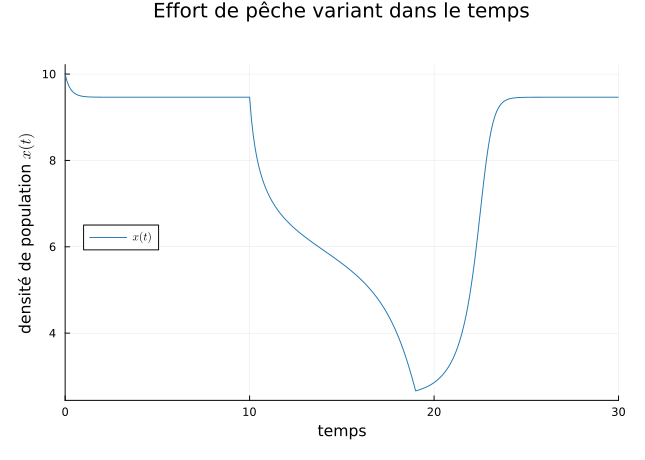

In [8]:
#| output: true

plot(sol_allee_evar,
     label = "\$x(t)\$",
     linewidht = 2,
     xlabel = "temps",
     ylabel = "densité de population \$x(t)\$",
     title = "Effort de pêche variant dans le temps",
     palette = :tab10,
     legend = :left,
     margin = .5Plots.cm,
     topmargin = 1Plots.cm)